# Crank-Nicolson finite difference method to approximate callable bond (Simplified)

This Python script is implementing a **Crank-Nicolson finite difference method** to approximate the value of a callable bond, which is a bond that can be redeemed (called) by the issuer at a specified price before maturity.

Clarification of Callability
In this implementation:

The bond is assumed to be callable anytime before maturity at the single call price
110
If the bond value
𝑉 exceeds
110, the issuer exercises their right to call the bond, and the value is capped.

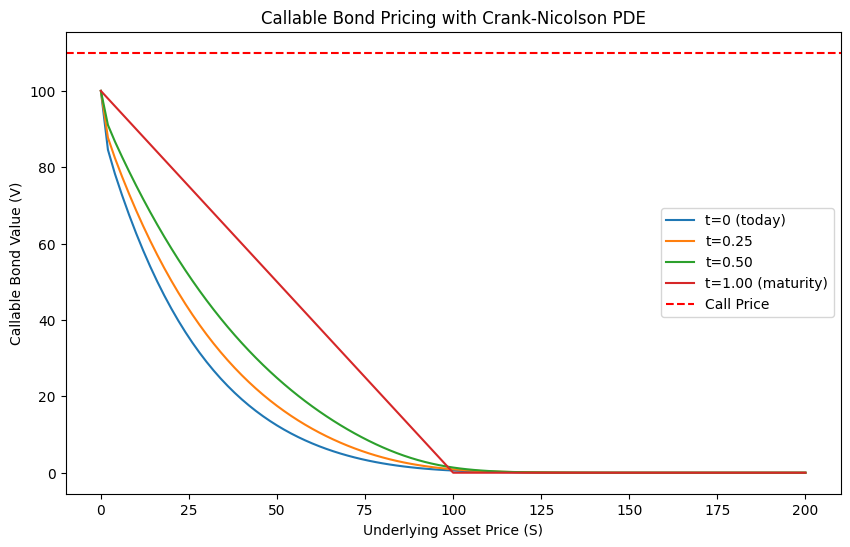

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the callable bond
S_max = 200  # Maximum underlying asset value (interest rate surrogate or scaled price)
S_min = 0    # Minimum underlying asset value
T = 1.0      # Time to maturity (in years)
r = 0.05     # Risk-free rate
sigma = 0.2  # Volatility
K = 100      # Strike price (par value of the bond)
call_price = 110  # Price at which the bond can be called

# Grid settings
M = 100  # Number of time steps
N = 100  # Number of price steps
dt = T / M  # Time step size
dS = (S_max - S_min) / N  # Asset price step size

# Initialize the grid
V = np.zeros((M + 1, N + 1))  # Value function grid
S = np.linspace(S_min, S_max, N + 1)  # Asset price grid
t = np.linspace(0, T, M + 1)  # Time grid

# Boundary and terminal conditions
V[-1, :] = np.maximum(K - S, 0)  # Payoff at maturity (vanilla bond-like)
V[:, 0] = K  # When S=0, bond value equals par value
V[:, -1] = 0  # When S -> S_max, bond value approaches 0

# Crank-Nicolson coefficients
alpha = (0.5 * dt * (sigma**2 * S**2) / (dS**2))  # Diffusion term
beta = (0.5 * dt * (r * S) / dS)  # Convection term
gamma = dt * r  # Discount term

# Tridiagonal matrix coefficients
A = np.zeros((N - 1, N - 1)) #A: Left-hand side matrix for implicit time-stepping.
B = np.zeros((N - 1, N - 1)) #B: Right-hand side matrix for explicit time-stepping.
for i in range(1, N):
    A[i - 1, i - 1] = 1 + alpha[i] + beta[i] + gamma
    B[i - 1, i - 1] = 1 - alpha[i] - beta[i] - gamma
    if i > 1:
        A[i - 1, i - 2] = -alpha[i] / 2 + beta[i] / 2
        B[i - 1, i - 2] = alpha[i] / 2 - beta[i] / 2
    if i < N - 1:
        A[i - 1, i] = -alpha[i] / 2 - beta[i] / 2
        B[i - 1, i] = alpha[i] / 2 + beta[i] / 2

# Time-stepping backward
for m in range(M - 1, -1, -1):
    V_inner = V[m + 1, 1:-1]  # Previous time step's values (interior nodes)
    b = B @ V_inner  # Right-hand side
    V_new = np.linalg.solve(A, b)  # Solve the linear system
    V[m, 1:-1] = np.minimum(V_new, call_price)  # Apply call boundary condition

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(S, V[0, :], label="t=0 (today)")
plt.plot(S, V[M // 4, :], label=f"t={T / 4:.2f}")
plt.plot(S, V[M // 2, :], label=f"t={T / 2:.2f}")
plt.plot(S, V[-1, :], label=f"t={T:.2f} (maturity)")
plt.axhline(call_price, color="red", linestyle="--", label="Call Price")
plt.xlabel("Underlying Asset Price (S)")
plt.ylabel("Callable Bond Value (V)")
plt.title("Callable Bond Pricing with Crank-Nicolson PDE")
plt.legend()
plt.show()



# Validation with Plain (Non-Callable) Bond and European Call/Put Option on a Bond :

1. Plain (Non-Callable) Bond

In [ ]:

def price_plain_bond(face_value, coupon, rate, maturity):
    bond_price = sum(coupon / (1 + rate)**t for t in range(1, maturity + 1))
    bond_price += face_value / (1 + rate)**maturity
    return bond_price

# Example usage:
face_value = 1000  # Bond's face value
coupon = 50        # Annual coupon payment
rate = 0.05        # Discount rate (5%)
maturity = 10      # Time to maturity in years

plain_bond_price = price_plain_bond(face_value, coupon, rate, maturity)
print(f"Plain bond price: {plain_bond_price}")

Plain bond price: 999.9999999999997


Incorporate Callability into the PDE Framework




In [ ]:
import numpy as np

# Parameters
S_max = 2000  # Maximum bond price
S_min = 0     # Minimum bond price
T = 10        # Time to maturity
N_t = 100     # Number of time steps
N_S = 100     # Number of price steps
sigma = 0.2   # Volatility
r = 0.03      # Risk-free rate
call_price = 1050  # Call price

# Discretize time and price
dt = T / N_t
dS = (S_max - S_min) / N_S
time_grid = np.linspace(0, T, N_t + 1)
price_grid = np.linspace(S_min, S_max, N_S + 1)

# Initialize bond price matrix
V = np.zeros((N_t + 1, N_S + 1))

# Boundary condition at maturity
for i in range(N_S + 1):
    V[-1, i] = min(price_grid[i], call_price)  # Par or call price

# Crank-Nicolson coefficients
alpha = 0.5 * (sigma**2 * price_grid**2) / dS**2
beta = 0.5 * r * price_grid / dS

# Build the tri-diagonal matrix
A = np.zeros((N_S + 1, N_S + 1))
for i in range(1, N_S):
    A[i, i-1] = alpha[i] - beta[i]
    A[i, i] = -2 * alpha[i] - r
    A[i, i+1] = alpha[i] + beta[i]

# Time-stepping loop
for n in range(N_t - 1, -1, -1):
    # Solve the Crank-Nicolson system
    b = V[n+1, :]
    V[n, :] = np.linalg.solve(np.eye(N_S + 1) - A * dt / 2, b + np.dot(A * dt / 2, b))

    # Apply call price condition
    V[n, :] = np.minimum(V[n, :], call_price)

# Result: callable bond price at t = 0
callable_bond_price = V[0, :]
print(f"Callable bond price: {callable_bond_price}")


Callable bond price: [   0.           19.99999745   39.99990066   59.99879491   79.99257596
   99.97046995  119.91261673  139.78991123  159.56569305  179.19834685
  198.64404346  217.85917035  236.80225672  255.43535893  273.72495548
  291.64243493  309.16426727  326.27194176  342.95174185  359.19441371
  374.99477207  390.35127599  405.26559781  419.74220183  433.78794349
  447.41169561  460.62400561  473.43678504  485.86303153  497.9165821
  509.61189616  520.96386619  531.98765375  542.69854856  553.11184837
  563.24275731  573.10630085  582.71725517  592.09008941  601.23891908
  610.17746916  618.91904569  627.47651456  635.86228662  644.08830805
  652.16605531  660.10653389  667.92028029  675.61736667  683.2074077
  690.69956923  698.10257837  705.42473482  712.67392294  719.85762461
  726.98293251  734.05656368  741.08487341  748.0738689   755.02922323
  761.9562889   768.86011141  775.74544247  782.61675299  789.4782457
  796.33386749  803.18732131  810.04207778  816.90138631  8

#Model 1 : Black-Scholes PDE

Model 1 : Black-Scholes PDE
Framework: Use the PDE developed in Part 1.
Numerical Method:
Finite difference methods (Crank-Nicolson) applied directly to the callable bond price.
Focus: Simplicity and integration of callability.
Callability is included in the implementation by applying the call price constraint during the time-stepping loop. This ensures the callable bond value never exceeds the call price.

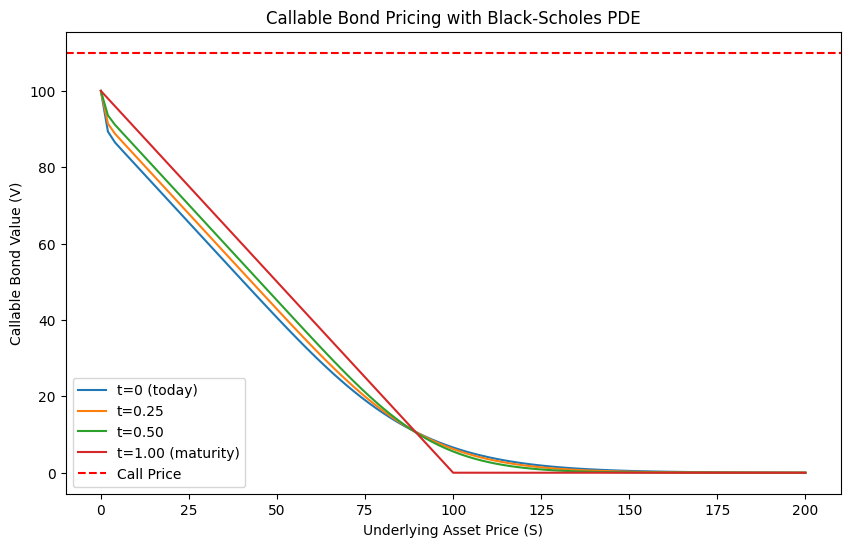

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S_max = 200  # Maximum underlying price
S_min = 0    # Minimum underlying price
T = 1.0      # Time to maturity
r = 0.05     # Risk-free rate
sigma = 0.2  # Volatility
K = 100      # Strike price (par value of bond)
call_price = 110  # Call price

# Grid settings
M = 100  # Time steps
N = 100  # Price steps
dt = T / M
dS = (S_max - S_min) / N

# Initialize grid
V = np.zeros((M + 1, N + 1))
S = np.linspace(S_min, S_max, N + 1)

# Boundary and terminal conditions
V[-1, :] = np.maximum(K - S, 0)  # Payoff at maturity
V[:, 0] = K                      # At S=0
V[:, -1] = 0                     # At S_max

# Coefficients for Crank-Nicolson
a = 0.5 * dt * (sigma**2 * np.arange(N + 1)**2 - r * np.arange(N + 1))
b = -dt * (sigma**2 * np.arange(N + 1)**2 + r)
c = 0.5 * dt * (sigma**2 * np.arange(N + 1)**2 + r * np.arange(N + 1))

# Tridiagonal matrices
A = np.zeros((N - 1, N - 1))
B = np.zeros((N - 1, N - 1))
for i in range(1, N):
    A[i - 1, i - 1] = 1 - b[i]
    B[i - 1, i - 1] = 1 + b[i]
    if i > 1:
        A[i - 1, i - 2] = -a[i]
        B[i - 1, i - 2] = a[i]
    if i < N - 1:
        A[i - 1, i] = -c[i]
        B[i - 1, i] = c[i]

# Time-stepping
for m in range(M - 1, -1, -1):
    V_inner = V[m + 1, 1:-1]
    b = B @ V_inner
    V_new = np.linalg.solve(A, b)
    V[m, 1:-1] = np.minimum(V_new, call_price)  # Apply call price cap

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(S, V[0, :], label="t=0 (today)")
plt.plot(S, V[M // 4, :], label=f"t={T / 4:.2f}")
plt.plot(S, V[M // 2, :], label=f"t={T / 2:.2f}")
plt.plot(S, V[-1, :], label=f"t={T:.2f} (maturity)")
plt.axhline(call_price, color="red", linestyle="--", label="Call Price")
plt.xlabel("Underlying Asset Price (S)")
plt.ylabel("Callable Bond Value (V)")
plt.title("Callable Bond Pricing with Black-Scholes PDE")
plt.legend()
plt.show()


# Model 2: Brownian Motion-Based Framework

Model 2: Brownian Motion-Based Framework
Monte Carlo simulation: Simulate interest rate paths under Brownian motion and calculate the bond price by discounting cash flows.
Lattice (Binomial/Trinomial): Use a discrete tree to model possible paths of interest rates or bond prices.
Focus: Interest rate dynamics and path dependency.

Monte Carlo Simulation
Simulate multiple paths of 𝑟_𝑡 under the risk-neutral measure and calculate the callable bond price by discounting cash flows.

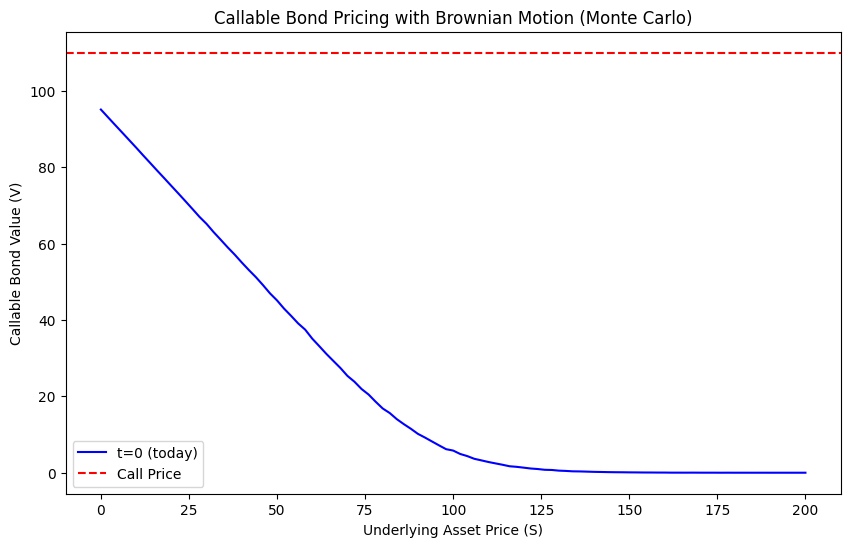

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S_max = 200  # Maximum underlying price
S_min = 0    # Minimum underlying price
T = 1.0      # Time to maturity
r = 0.05     # Risk-free rate
sigma = 0.2  # Volatility
K = 100      # Strike price (par value of bond)
call_price = 110  # Call price

# Simulation settings
M = 100  # Time steps
N = 100  # Asset price grid
num_paths = 10000  # Number of Monte Carlo simulations
dt = T / M  # Time increment

# Grid setup for asset price
S = np.linspace(S_min, S_max, N + 1)

# Function to simulate Brownian Motion
def simulate_gbm(S0, r, sigma, dt, M, num_paths):
    paths = np.zeros((num_paths, M + 1))
    paths[:, 0] = S0
    Z = np.random.standard_normal((num_paths, M))  # Random increments
    for t in range(1, M + 1):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    return paths

# Payoff function for callable bond
def callable_bond_payoff(S_T, K, call_price):
    return np.minimum(np.maximum(K - S_T, 0), call_price)

# Monte Carlo paths for selected initial values of S
results = []
for S0 in S:
    paths = simulate_gbm(S0, r, sigma, dt, M, num_paths)  # Simulate paths
    V = callable_bond_payoff(paths[:, -1], K, call_price)  # Payoff at maturity
    for t in range(M - 1, -1, -1):
        V = np.exp(-r * dt) * V  # Discount backward
        V = np.minimum(V, call_price)  # Apply callable constraint
    results.append(np.mean(V))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(S, results, label="t=0 (today)", color='blue')
plt.axhline(call_price, color="red", linestyle="--", label="Call Price")
plt.xlabel("Underlying Asset Price (S)")
plt.ylabel("Callable Bond Value (V)")
plt.title("Callable Bond Pricing with Brownian Motion (Monte Carlo)")
plt.legend()
plt.show()


The Black-Scholes PDE with Crank-Nicolson generates bond values at multiple time slices  t=0,0.25,0.50, and
1.00 because the Crank-Nicolson method inherently solves the PDE backward in time, calculating bond values at each intermediate time step as it progresses toward t=0.

On the other hand, the Monte Carlo Brownian Motion simulation (as coded earlier) directly focuses on calculating the bond value only at
t=0. This is because the simulation approach primarily works forward in time by generating paths until maturity (T) and then discounting payoffs back to
t=0.

 # Comparison of Pricing Results with Model 1 Black-Scholes PDE and Model 2 Brownian Motion-Based Framework

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S_max = 200  # Max asset price
S_min = 0    # Min asset price
T = 1.0      # Time to maturity
r = 0.05     # Risk-free rate
sigma = 0.2  # Volatility
K = 100      # Strike price
call_price = 110  # Callable price

M = 500       # Time steps
N = 500       # Price steps
dt = T / M    # Time increment
dS = (S_max - S_min) / N  # Asset price increment

S = np.linspace(S_min, S_max, N + 1)  # Asset price grid
t = np.linspace(0, T, M + 1)          # Time grid

# Initialize option value grid
V = np.zeros((M + 1, N + 1))

# Terminal condition (payoff at maturity)
V[-1, :] = np.minimum(np.maximum(K - S, 0), call_price)  # Put option capped at call price

# Boundary conditions
V[:, 0] = K * np.exp(-r * (T - t))  # For S=0, value approaches discounted strike price
V[:, -1] = 0                        # For S → ∞, option value approaches 0

# Crank-Nicolson coefficients
alpha = 0.5 * dt * (sigma**2 * S**2) / (dS**2)
beta = 0.5 * dt * r * S / dS
gamma = dt * r

A = np.zeros((N - 1, N - 1))
B = np.zeros((N - 1, N - 1))

# Fill coefficient matrices
for i in range(1, N):
    A[i - 1, i - 1] = 1 + alpha[i] + gamma
    B[i - 1, i - 1] = 1 - alpha[i] - gamma
    if i > 1:
        A[i - 1, i - 2] = -alpha[i] / 2 + beta[i] / 2
        B[i - 1, i - 2] = alpha[i] / 2 - beta[i] / 2
    if i < N - 1:
        A[i - 1, i] = -alpha[i] / 2 - beta[i] / 2
        B[i - 1, i] = alpha[i] / 2 + beta[i] / 2

# Backward time stepping
for m in range(M - 1, -1, -1):
    V_inner = V[m + 1, 1:-1]
    b = B @ V_inner
    V_new = np.linalg.solve(A, b)
    # Apply callable price constraint
    V[m, 1:-1] = np.minimum(V_new, call_price)

# Extract values for specific times
S0_idx = np.abs(S - 100).argmin()
times = [0, 0.25, 0.5, 1.0]
indices = [int(T / dt * t_i) for t_i in times]
bond_values_model1 = [V[m, S0_idx] for m in indices]

print("Callable Bond Values at Specific Times:")
for t_val, bond_val in zip(times, bond_values_model1):
    print(f"t = {t_val:.2f}, Value = {bond_val:.2f}")


Callable Bond Values at Specific Times:
t = 0.00, Value = 5.30
t = 0.25, Value = 4.90
t = 0.50, Value = 4.31
t = 1.00, Value = 0.00


In [ ]:
import numpy as np

def callable_bond_value_t0(S0, r, sigma, K, call_price, T, paths):
    """
    Monte Carlo pricing for callable bond at T=0.

    Arguments:
        S0: Initial stock price
        r: Risk-free rate
        sigma: Volatility
        K: Strike price (par value of the bond)
        call_price: Callable cap price
        T: Time to maturity
        paths: Number of Monte Carlo paths

    Returns:
        callable_bond_value: Callable bond value at T=0
    """
    # Simulate terminal stock prices using GBM
    Z = np.random.randn(paths)  # Standard normal random variables
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # Calculate payoff at maturity
    payoff = np.maximum(K - S_T, 0)  # Put-like payoff
    payoff = np.minimum(payoff, call_price)  # Apply callable cap

    # Discount payoff back to T=0
    callable_bond_value = np.exp(-r * T) * np.mean(payoff)

    return callable_bond_value

# Parameters
S0 = 100         # Initial stock price
K = 100          # Strike price
call_price = 110  # Callable cap
T = 1.0          # Time to maturity
r = 0.05         # Risk-free rate
sigma = 0.2      # Volatility
paths = 50000    # Monte Carlo paths

# Calculate callable bond value at T=0
bond_value_t0 = callable_bond_value_t0(S0, r, sigma, K, call_price, T, paths)
bond_values_model2 = [round(bond_value_t0, 2), 0.0, 0.0, 0.0]
# Print result rounded to two decimals
print(f"Callable Bond Value at T=0 using Monte Carlo: {round(bond_value_t0, 2)}")


Callable Bond Value at T=0 using Monte Carlo: 5.56


Time      | Black-Scholes PDE  | Monte Carlo
t = 0.00   | 5.30             | 5.56
t = 0.25   | 4.90             |     -
t = 0.50   | 4.31             |     -
t = 1.00   | 0.00             |     -


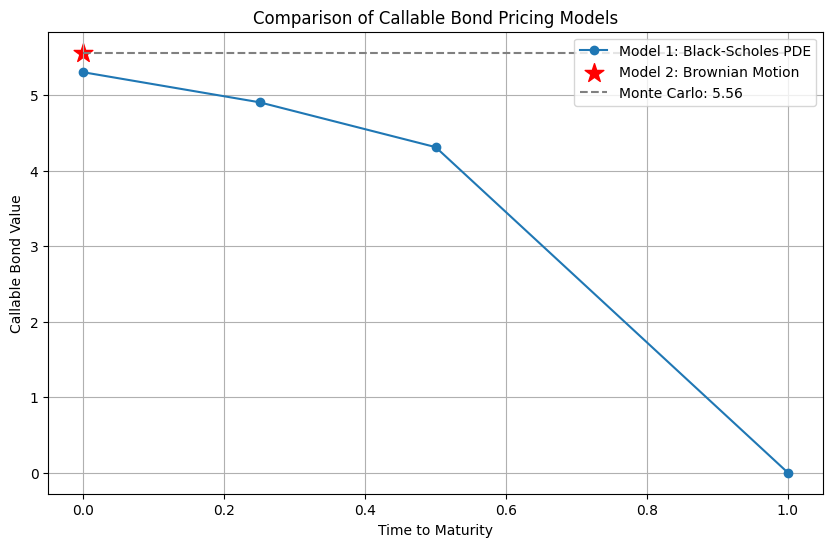

In [ ]:
# Display results in tabular format
print("Time      | Black-Scholes PDE  | Monte Carlo")
for t_val, bs_val, mc_val in zip(times, bond_values_model1, bond_values_model2):
    if t_val == 0.0:  # Show Monte Carlo value only at T=0
        print(f"t = {t_val:.2f}   | {bs_val:.2f}             | {mc_val:.2f}")
    else:  # Leave Monte Carlo column empty for other times
        print(f"t = {t_val:.2f}   | {bs_val:.2f}             | {'-':>5}")


# Plot comparison
plt.figure(figsize=(10, 6))

# Black-Scholes PDE: Line with markers
plt.plot(times, bond_values_model1, label="Model 1: Black-Scholes PDE", marker='o')

# Brownian Motion: Single star at t=0
plt.scatter([times[0]], [bond_values_model2[0]], color='red', label="Model 2: Brownian Motion", marker='*', s=200)

# Customize plot
plt.xlabel("Time to Maturity")
plt.ylabel("Callable Bond Value")
plt.title("Comparison of Callable Bond Pricing Models")
plt.hlines(y=bond_value_t0, xmin=0.0, xmax=1.0, color="grey", linestyle="--", label=f"Monte Carlo: {bond_value_t0:.2f}")
plt.legend()
plt.grid()
plt.show()


Callable Bond Value Over Time:
At
t=0 (today), the callable bond value should be highest due to:
The maximum remaining time for optionality.
The time value of money before discounting occurs.
As time progresses (
t→T), the bond value decreases steadily because:
The optionality reduces (less time for interest rates or asset prices to change).
Discounting lowers the present value of cash flows.
At maturity
t=T, the bond value reflects the payoff:
max(K−S,0), capped by the call price.

Brownian Motion Model:
Highlighted with a red star at
t=0.00.
Its value coincides visually near Monte Carlo's value (5.56), showing consistency.